Length edges: 8
Source: s
Sink  : t
----------------------------------



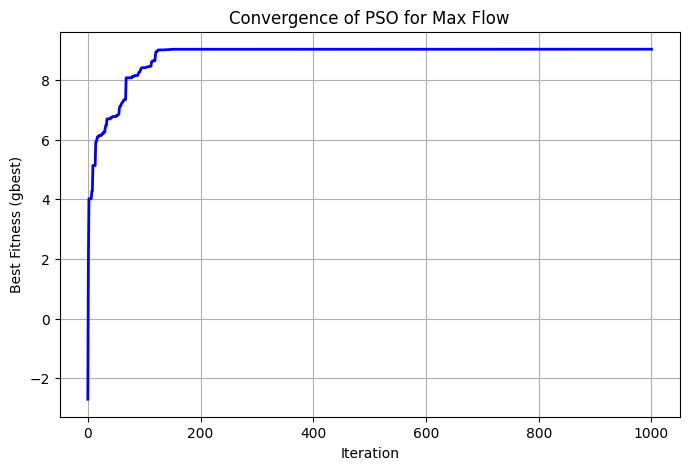

In [85]:
import pandas as pd
import random 
from copy import deepcopy
import matplotlib.pyplot as plt

#Đọc file (sau này xoá)
file=r'Graphs_edges.csv'
edges_df=pd.read_csv(file)

#Chuyển thành danh sách kề
def adj_list_from_file(dataframe):
    #Input : 
    #dataframe : dataframe đọc từ file graph(dataframe)

    #Output
    #adj_list : danh sách kề (dictionary)
    #khởi tọ
    adj_list={}
    for index,rows in dataframe.iterrows():
        v_from=rows.v_from
        v_to  =rows.v_to
        weight=rows.weight
        #Chưa có thì thêm vào
        if v_from not in adj_list:
            adj_list[v_from]=[]
        #thêm cạnh
        adj_list[v_from].append((v_to,weight))
        #đảm bảo v_to có mặt dù không có cạnh đi(là cạnh đích)
        if v_to not in adj_list:
            adj_list[v_to]=[]
    return adj_list

#Chuyển đồ thị -> edges & capacity
def build_edges_and_capacity_from_adj_list(adj_list):
    #edges: danh sách cạnh kiểu tuple (u,v)
    #capacity: list tải trọng
    edges=[]
    capacity=[]
    for u,neighbors in adj_list.items():
        for v,cap in neighbors:
            edges.append((u,v))
            capacity.append(float(cap))
    return edges,capacity

#Chuyển từ vector flow -> tính flow_in và flow_out cho mỗi node
def flows_from_vector(edges,flow_vector):
    #trả về dictionary (u,v) -> là 1 luồng (flow)
    return {edges[i]: float(flow_vector[i]) for i in range(len(edges))}
def node_flow_balance(edges,flow_vector):
    flow_in  = {}
    flow_out = {}
    for (u,v),f in zip(edges,flow_vector):
        flow_out.setdefault(u,0.0)
        flow_in.setdefault(u,0.0)
        flow_out.setdefault(v,0.0)
        flow_in.setdefault(v,0.0)
        flow_out[u] +=f
        flow_in[v]  +=f
    return flow_in,flow_out

#Hàm fitness (càng lớn càng tốt)
def fitness_of_vector(edges,capacities,flow_vector,source,sink,alpha=10.0,beta=10.0):
    #fitness = toàn bộ luồng đi ra từ source - penalty
    #penalty = alpha * sum(capacity violation^2) + beta * sum(flow conservation violation^2)

    #tổng luồng rời source
    flow_map=flows_from_vector(edges,flow_vector)
    total_from_source=0.0
    for i,(u,v) in enumerate(edges):
        if u == source:
            total_from_source+=flow_vector[i]
    
    #penalty cho việc vector bị vượt capacity
    penalty_cap=0.0
    for i,f in enumerate(flow_vector):
        if f < 0:
            penalty_cap += (-f)**2 # phòng nếu có âm
        if f > capacities[i]:
            penalty_cap += (f-capacities[i])**2
    #penalty cho việc bảo toàn luồng ở các node(trừ source và sink)
    flow_in,flow_out=node_flow_balance(edges,flow_vector)
    penalty_cons=0.0
    nodes=set([u for u,v in edges] + [v for u,v in edges])
    for node in nodes:
        if node in (source,sink):
            continue
        diff=flow_in.get(node,0.0) - flow_out.get(node,0.0)
        penalty_cons+= diff**2 
    fitness=total_from_source - alpha*penalty_cap - beta*penalty_cons
    return fitness

#Thuật toán pso giải max flow
def pso_max_flow(edges,capacities,source,sink,num_particles=30
                 ,max_loop=300,w=0.7,c1=1.5,c2=1.5
                 ,alpha=20.0,beta=20.0,seed=None,verbose=False):
    #Trả về best_vector (danh sách luồng), best fitness,history_best
    if seed is not None:
        random.seed(seed)
    n=len(edges)
    #khởi tạo swarm: vị trí (flow) và vận tốc
    swarm_x = [[random.uniform(0.0, capacities[j]) for j in range(n)] for _ in range(num_particles)]
    swarm_v = [[0.0 for _ in range(n)] for _ in range(num_particles)]

    #tạo pbest(personal best)
    pbest_x = deepcopy(swarm_x)
    pbest_val = [fitness_of_vector(edges, capacities, x, source, sink, alpha, beta) for x in pbest_x]
    #tạo gbest(global best)
    gbest_idx=max(range(num_particles),key=lambda i:pbest_val[i])
    gbest_x=deepcopy(pbest_x[gbest_idx])
    gbest_val=pbest_val[gbest_idx]

    history=[gbest_val]

    for it in range(max_loop):
        for i in range(num_particles):
            x = swarm_x[i]
            v = swarm_v[i]

            # cập nhật velocity & position
            for j in range(n):
                r1 = random.random()
                r2 = random.random()
                cognitive = c1 * r1 * (pbest_x[i][j] - x[j])
                social = c2 * r2 * (gbest_x[j] - x[j])
                v[j] = w * v[j] + cognitive + social

                # cập nhật x
                x[j] = x[j] + v[j]

                # clamp 0..capacity
                if x[j] < 0.0:
                    x[j] = 0.0
                    v[j] = 0.0
                if x[j] > capacities[j]:
                    x[j] = capacities[j]
                    v[j] = 0.0

            # evaluate
            val = fitness_of_vector(edges, capacities, x, source, sink, alpha, beta)

            # update personal best
            if val > pbest_val[i]:
                pbest_val[i] = val
                pbest_x[i] = x.copy()

            # update global best
            if val > gbest_val:
                gbest_val = val
                gbest_x = x.copy()

        history.append(gbest_val)
        if verbose and (it % max(10, max_loop//10) == 0):
            print(f"Loop {it:4d}  gbest_val = {gbest_val:.6f}")

    return gbest_x, gbest_val, history

#Hàm hiển thị kết quả vector chuyển về dict dễ nhìn
def vector_to_edge_flow_dict(edges,vector):
    #input : 
    #edges : danh sách cạnh
    #vector : danh sách vector

    #output: dictionary
    return {edges[i] : vector[i] for i in range(len(edges))}

#hàm in solution
def print_solution(edges,vector,capacities):
    d=vector_to_edge_flow_dict(edges,vector)
    print("Edge flows (u->v : flow / capacity):")
    for (u, v), f in d.items():
        print(f"{u} -> {v} : {f:.3f} / {capacities[edges.index((u,v))]}")

#----------------------#

#HÀM CHẠY GIẢI THUẬT (mấy hàm trên đừng để ý chỉ cần biết hàm chạy và tham số là được)

#----------------------#

def run_pso_max_flow(dataframe_of_graph,source,sink,num_particles=40,max_loop=300,
                    w=0.7, c1=1.5, c2=1.5,
                    alpha=30.0, beta=30.0,seed=42,verbose=True):
    #Hàm chạy toàn bộ PSO Max Flow từ A→Z
    #- adj_list: dictionary đồ thị {u: [(v, capacity)]}
    #- trả về: best_vector, best_value, history

    # 1) Build edges + capacities
    #chuyển datarame thành adj_list
    adj_list=adj_list_from_file(dataframe_of_graph)
    edges, capacities = build_edges_and_capacity_from_adj_list(adj_list)

    print("Length edges:", len(edges))
    print("Source:", source)
    print("Sink  :", sink)
    print("----------------------------------\n")

    # 2) Chạy PSO
    best_vec, best_val, history = pso_max_flow(edges, capacities, source, sink,
                                               num_particles=num_particles,
                                               max_loop=max_loop,
                                               w=w, c1=c1, c2=c2,
                                               alpha=alpha, beta=beta,
                                               seed=seed,
                                               verbose=verbose)

    # 3) In kết quả
    if verbose:
        print("\n===== Final result =====")
        print(f"Best fitness (approximately): {best_val:.6f}")
        total_from_source = sum(
            best_vec[i] for i, (u, v) in enumerate(edges) if u == source)
        print(f"Total actual flow from source:  {total_from_source:.6f}")
        print("\nFlows on edges:")
        print_solution(edges, best_vec, capacities)

    return best_vec, best_val, history

best_vec, best_val, history = run_pso_max_flow(
    dataframe_of_graph=edges_df,
    source='s',
    sink='t',
    num_particles=50,
    max_loop=1000,
    w=0.7, c1=1.5, c2=2.0,
    alpha=10.0, beta=10.0,
    seed=random.random(),
    verbose=False
)
plt.figure(figsize=(8,5))
plt.plot(history, color='blue', linewidth=2)
plt.title("Convergence of PSO for Max Flow")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness (gbest)")
plt.grid(True)
plt.show()